## Introduction to Artificial Neural Networks

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/08_neural_nets_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/08_neural_nets_with_pytorch.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

In [1]:
!pip install torchinfo -qq

In [8]:
# Python ≥3.7 is recommended
import sys
assert sys.version_info >= (3, 7)
import os
from pathlib import Path
from time import strftime
import gc

# Scikit-Learn ≥1.01 is recommended
from packaging import version
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# Pytorch related
import torch
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchinfo import summary
from fastai.vision.all import *

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# to make this notebook's output stable across runs
np.random.seed(42)
torch.manual_seed(42)

In [3]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 48.8 MB/s eta 0:00:00


In [5]:
if not torch.cuda.device_count():
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Perceptrons

Let's use the iris dataset from openml. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica

<center> <img src="https://drive.google.com/uc?id=1YdzLV9grRNMQaaDz7JHEhj_TbTzr9NDJ" alt="drawing" width="600"/> </center>

You can find more information about the dataset [here](https://api.openml.org/d/61).

In [9]:
iris = load_iris(as_frame=True)
print(iris.data.shape)
iris.data.head()

(150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


For simplicity, here we perform binary classification based on two features.

In [10]:
# Choose two features and setup a binary classification problem
X = iris.data[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = (iris.target == 0)  # Iris setosa

# Build Perceptron model
per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

# Test on two new instances
X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers
y_pred

array([ True, False])

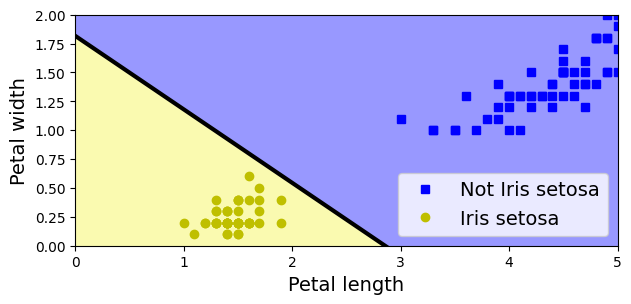

In [11]:
# Plot the decision boundary

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

# Tensorflow Playground

[http://playground.tensorflow.org/](http://playground.tensorflow.org/)

## Introduction 
The Playground provides mainly 6 different types of datasets.
1.   Classification: Circle, Exclusive or, Gaussian, spiral.
2.   Regression: Plane, Multi Gaussian.

Small circle points are represented as data points that correspond to Positive (+) and Negative (-). Positive represented by blue, Negative represented by orange. These same colours are used in representing Data, Neuron, Weight values.

The datasets all have 2 input features and 1 output label. The 2 input features, `X1` and `X2`, are represented by the coordinates. 

* The data points (represented by small circles) are initially colored orange or blue, which correspond to positive one and negative one.

* In the hidden layers, the lines are colored by the weights of the connections between neurons. Blue shows a positive weight, which means the network is using that output of the neuron as given. An orange line shows that the network is assiging a negative weight.

* In the output layer, the dots are colored orange or blue depending on their original values. The background color shows what the network is predicting for a particular area. **The intensity of the color shows how confident that prediction is**

## Try it
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.

* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster.

* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.

* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.

* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.

* **Deep net and vanishing gradients**: now change the dataset to be the spiral  (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 4 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.

# Building an Image Classifier Using the Sequential API

First let's import pytorch.

In [12]:
torch.__version__

'2.0.0+cu118'

First, we need to load a dataset. We will tackle Fashion MNIST, which is a drop-in replacement of MNIST. It has the exact same format as MNIST (70,000 grayscale images of $28 \times 28$ pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse and the problem turns out to be significantly more challenging than MNIST. **For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST.**

Let's start by loading the fashion MNIST dataset. `Pytorch` has a number of functions to load popular datasets in `datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [13]:
transform = transforms.Compose([transforms.ToTensor(), lambda x: x/255])

trainset = datasets.FashionMNIST(
    root="data",            
    train=True,             
    download=True,         
    transform=transform,  
)

testset = datasets.FashionMNIST(
    root="data",           
    train=False,           
    download=True,         
    transform=transform,
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15937675.15it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271715.97it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5055744.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20841966.21it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's split the full training set into a validation set and a (smaller) training set. Now the validation set contains 5,000 images, and the test set contains 10,000 images.

In [14]:
# Preparing for validaion test

trainset, validset = torch.utils.data.random_split(trainset, [55000, 5000])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Notice that the order of Pytorch is `[batch, channel, height, width]`.

In [15]:
for X, y in trainloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    print(y)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64
tensor([3, 4, 5, 7, 7, 0, 6, 2, 0, 1, 1, 5, 2, 8, 8, 0, 5, 1, 8, 7, 7, 3, 4, 1,
        5, 1, 0, 9, 6, 7, 3, 0])


The labels are the class IDs from 0 to 9.

Here are the corresponding class names:

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Let's take a look at a sample of the images in the dataset:

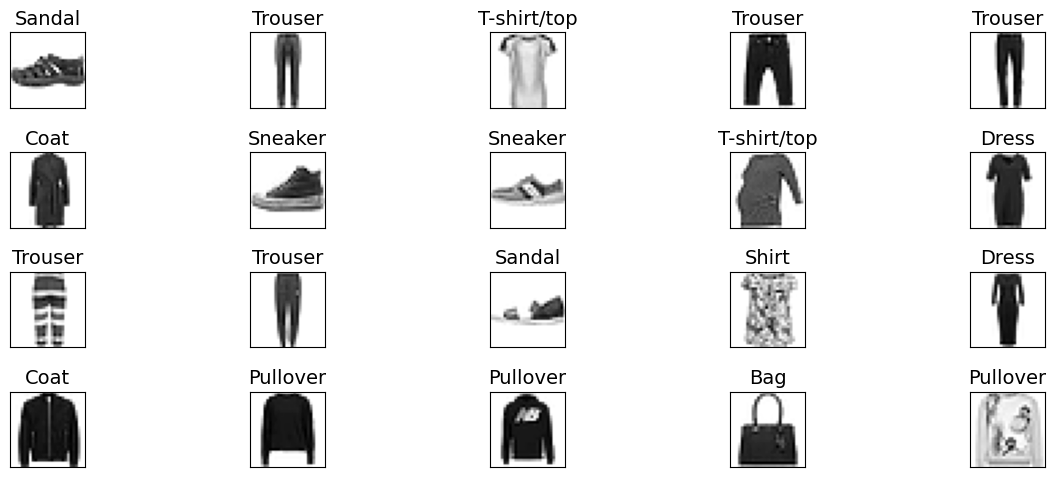

In [18]:
dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='binary')
   # .item() gets the value contained in a Tensor
  ax.set_title(class_names[labels[idx].item()])
  fig.tight_layout()

## Creating the Model Using the Sequential API
Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [47]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

* We build the first layer and add it to the model. It is a `Flatten` layer whose role is simply to convert each input image into a 1D array: if it receives input data `X`, it computes `X.reshape(-1, 1)`. This layer does not have any parameters, it is just there to do some simple preprocessing. 
* Next we add a `Linear` hidden layer with 300 neurons. It will use the `ReLU` activation function. Each `Linear` layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of weight bias terms (one per neuron in the next layer). 
* Next we add a second `Linear` hidden layer with 100 neurons, also using the `ReLU` activation function.
* Finally, we add a `Linear` output layer with 10 neurons (one per class)

The model’s `summary()` method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters. Since we have not specified the shape of input in the model definition, **you should specify the input shape**. 

In [48]:
summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 10]                  --
├─Flatten: 1-1                           [32, 784]                 --
├─Linear: 1-2                            [32, 300]                 235,500
├─ReLU: 1-3                              [32, 300]                 --
├─Linear: 1-4                            [32, 100]                 30,100
├─ReLU: 1-5                              [32, 100]                 --
├─Linear: 1-6                            [32, 10]                  1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 8.53
Input size (MB): 0.10
Forward/backward pass size (MB): 0.10
Params size (MB): 1.07
Estimated Total Size (MB): 1.27

Note that Linear layers often have a lot of parameters. For example, the first hidden layer has `784×300` connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data!

All the parameters of a layer can be accessed using `parameters` or `named_parameters`. For a Linear layer, this includes both the connection weights and the bias terms:

In [49]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=10, bias=True)
)

In [50]:
for name, param in model[1].named_parameters():
    print(name, param)
    print(param.shape)

weight Parameter containing:
tensor([[-0.0008,  0.0200,  0.0067,  ..., -0.0131, -0.0300,  0.0034],
        [-0.0015, -0.0090,  0.0235,  ..., -0.0063,  0.0129,  0.0004],
        [-0.0313,  0.0174, -0.0309,  ..., -0.0151, -0.0003, -0.0060],
        ...,
        [-0.0189,  0.0302,  0.0253,  ...,  0.0066, -0.0163,  0.0019],
        [-0.0316,  0.0122,  0.0078,  ...,  0.0180, -0.0269,  0.0266],
        [-0.0120, -0.0033, -0.0263,  ...,  0.0092, -0.0053, -0.0234]],
       device='cuda:0', requires_grad=True)
torch.Size([300, 784])
bias Parameter containing:
tensor([-9.2447e-03, -2.8974e-02,  7.2220e-03, -3.3954e-02,  2.2371e-02,
         1.8663e-02, -4.9257e-03, -2.1786e-02, -6.3649e-06,  1.6387e-02,
        -2.2864e-02,  5.9067e-03,  7.7610e-03, -6.7648e-03,  2.9585e-04,
        -2.6493e-02, -5.4183e-03,  7.9403e-03, -8.6405e-03,  2.9657e-02,
         1.5868e-02, -9.9445e-03,  1.7332e-02, -2.3654e-02,  2.2842e-02,
         2.5317e-02,  2.4360e-02, -8.2912e-03,  3.1216e-02,  1.5463e-02,
     

Notice that the Linear layer initialized the connection weights randomly (which is needed to break symmetry).

## Compiling the Model

Here, we use the high-level API [fastai](https://docs.fast.ai/) for training, but you may also use [Lighting](https://www.pytorchlightning.ai/index.html) instead.

In [51]:
data = DataLoaders(trainloader, validloader)

In [52]:
learn = Learner(data, model, loss_func=F.cross_entropy, opt_func=Adam, metrics=[accuracy])

## Training and Evaluating the Model

In [53]:
learn.fit(30, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.790450,0.780884,0.720000,00:20
1,0.686098,0.695901,0.753200,00:17
2,0.553506,0.608219,0.786600,00:19
3,0.513209,0.545953,0.813400,00:20
4,0.479568,0.516947,0.819800,00:18
5,0.488435,0.491999,0.831600,00:17
6,0.440884,0.468577,0.836600,00:22
7,0.458791,0.459762,0.840800,00:22
8,0.409206,0.452688,0.839600,00:19
9,0.386557,0.436145,0.847200,00:21


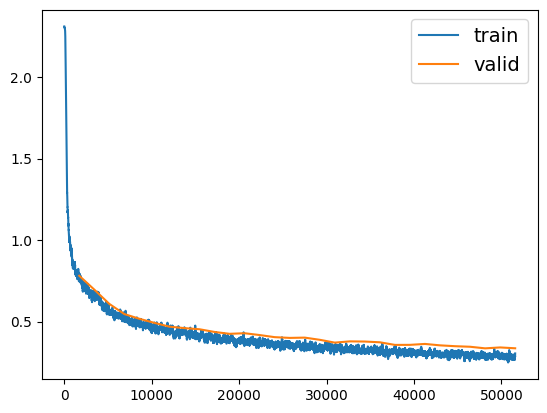

In [54]:
learn.recorder.plot_loss()

In [55]:
fastai_loss, fastai_accuracy = learn.validate(dl=testloader)

In [56]:
fastai_accuracy

0.8761000037193298

**It is common to get slightly lower performance on the test set
than on the validation set, because the hyperparameters are tuned on the validation set**, not the test set (however, in this example, we did not do any hyperparameter tuning, so the lower accuracy is just bad luck).

## Using the Model to Make Predictions

In [57]:
# Use the model to make predictions on the new data
predictions, labels = learn.get_preds(dl=testloader)

# Print the predicted classes and their corresponding true labels
print('Predicted probs:', predictions)
print('Predicted labels:', labels)

Predicted probs: tensor([[-10.3676, -10.8953, -11.4818,  ...,   2.2426,  -1.8765,   4.7194],
        [ -2.0989,  -9.2065,   7.2844,  ..., -51.7720,  -8.7795, -46.2127],
        [ -2.0484,   6.5507,  -6.7518,  ..., -23.1491, -10.7383, -26.7502],
        ...,
        [ -5.0137, -16.9200, -10.1650,  ..., -22.1841,   0.7203, -21.2843],
        [ -5.0028,   5.4822,  -7.8417,  ..., -11.9855, -12.1367, -15.4872],
        [ -7.9864,  -6.1703,  -5.9303,  ...,  -2.6586,  -2.9111,  -7.0408]])
Predicted labels: tensor([9, 2, 1,  ..., 8, 1, 5])


You can also use plain `Pytorch` to do the inference:

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)      
        # prediction
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

data_count = len(testloader.dataset)
percentage = 100. * correct / data_count
print(percentage)

87.61


## Try different network architecture and hyperparameters

In [60]:
learn = None
model = None
gc.collect()
torch.cuda.empty_cache()

In [61]:
# Sometimes applying BN before the activation function works better (there's a debate on this topic)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 300),
    torch.nn.BatchNorm1d(300, momentum=0.99, eps=0.001),
    torch.nn.PReLU(300),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(300, 100),
    torch.nn.BatchNorm1d(100, momentum=0.99, eps=0.001),
    torch.nn.PReLU(100),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

In [62]:
summary(model, input_size=(32, 1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 10]                  --
├─Flatten: 1-1                           [32, 784]                 --
├─Linear: 1-2                            [32, 300]                 235,500
├─BatchNorm1d: 1-3                       [32, 300]                 600
├─PReLU: 1-4                             [32, 300]                 300
├─Dropout: 1-5                           [32, 300]                 --
├─Linear: 1-6                            [32, 100]                 30,100
├─BatchNorm1d: 1-7                       [32, 100]                 200
├─PReLU: 1-8                             [32, 100]                 100
├─Dropout: 1-9                           [32, 100]                 --
├─Linear: 1-10                           [32, 10]                  1,010
├─LogSoftmax: 1-11                       [32, 10]                  --
Total params: 267,810
Trainable params: 267,810
Non-trainable params:

In [63]:
data = DataLoaders(trainloader, validloader)

In [64]:
learn = Learner(data, model, loss_func=F.cross_entropy, opt_func=Adam, metrics=[accuracy])

SuggestedLRs(valley=0.0008317637839354575)

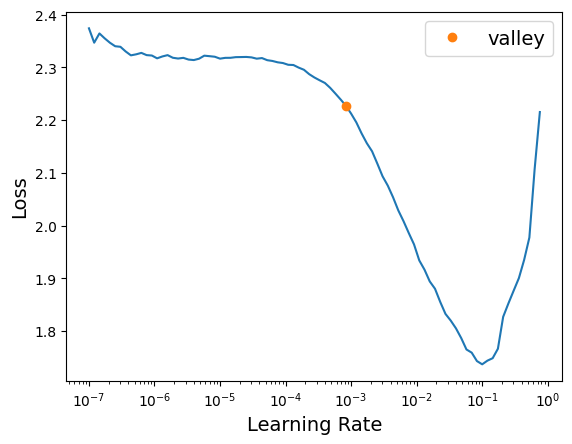

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(30, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.536114,0.492205,0.831200,00:22
1,0.500279,0.457570,0.833200,00:24
2,0.503207,0.490403,0.826600,00:29
3,0.502929,0.447084,0.839400,00:29
4,0.469937,0.420875,0.853600,00:24
5,0.481606,0.436684,0.848200,00:22
6,0.485776,0.417646,0.853000,00:22
7,0.468681,0.394094,0.863200,00:22
8,0.453838,0.423227,0.844600,00:22
9,0.446407,0.413163,0.850400,00:22


# Saving and Restoring

See [https://jonathan-sands.com/deep%20learning/fastai/pytorch/vision/classifier/2020/11/15/MNIST.html](https://jonathan-sands.com/deep%20learning/fastai/pytorch/vision/classifier/2020/11/15/MNIST.html) and [https://benjaminwarner.dev/2021/10/01/inference-with-fastai](https://benjaminwarner.dev/2021/10/01/inference-with-fastai)

In [67]:
learn.save("fastai")

Path('models/fastai.pth')

In [68]:
learn.load('fastai')

In [69]:
fastai_loss, fastai_accuracy = learn.validate(dl=testloader)

In [70]:
fastai_accuracy

0.8823999762535095

You can also save `Pytorch` model only:

In [71]:
torch.save(model, "my_torch_model")

In [72]:
model = torch.load("my_torch_model")

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)      
        # prediction
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

data_count = len(testloader.dataset)
percentage = 100. * correct / data_count
print(percentage)

88.24


# Using Callbacks during Training

In [44]:
learn = None
model = None
gc.collect()
torch.cuda.empty_cache()

In [45]:
# Sometimes applying BN before the activation function works better (there's a debate on this topic)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 300),
    torch.nn.BatchNorm1d(300, momentum=0.99, eps=0.001),
    torch.nn.PReLU(300),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(300, 100),
    torch.nn.BatchNorm1d(100, momentum=0.99, eps=0.001),
    torch.nn.PReLU(100),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

learn = Learner(data, model, loss_func=F.cross_entropy, opt_func=Adam, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time
0,0.502928,0.479331,0.827400,00:24
1,0.533826,0.466613,0.828200,00:24
2,0.518706,0.473331,0.827200,00:21
3,0.480978,0.529183,0.822000,00:20
4,0.506808,0.405815,0.853000,00:22
5,0.477145,0.471803,0.843000,00:23
6,0.474596,0.410654,0.855800,00:23
7,0.457896,0.422041,0.853000,00:21
8,0.450831,0.419836,0.852800,00:22
9,0.425248,0.401135,0.855000,00:22


Better model found at epoch 0 with valid_loss value: 0.47933071851730347.


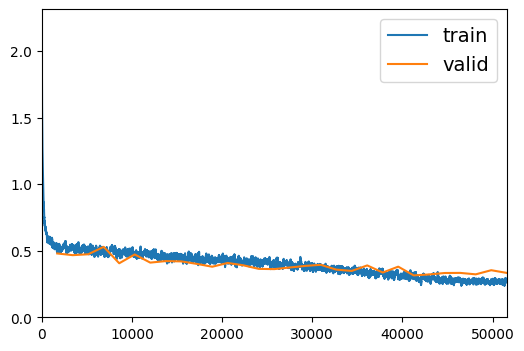

Better model found at epoch 1 with valid_loss value: 0.46661290526390076.
Better model found at epoch 4 with valid_loss value: 0.4058149755001068.
Better model found at epoch 9 with valid_loss value: 0.40113452076911926.
Better model found at epoch 10 with valid_loss value: 0.3797314167022705.
Better model found at epoch 13 with valid_loss value: 0.3636534810066223.
Better model found at epoch 14 with valid_loss value: 0.3618128001689911.
Better model found at epoch 18 with valid_loss value: 0.35813993215560913.
Better model found at epoch 19 with valid_loss value: 0.34811756014823914.
Better model found at epoch 21 with valid_loss value: 0.336223304271698.
Better model found at epoch 23 with valid_loss value: 0.31458228826522827.


In [46]:
learn.fit_one_cycle(30, 0.01, cbs=[SaveModelCallback(monitor='valid_loss', fname='model', at_end=True), ShowGraphCallback()])

# Pytorch references

1. [https://ithelp.ithome.com.tw/articles/10285392](https://ithelp.ithome.com.tw/articles/10285392) - Pytorch also has functional and subclassing API!

2. [https://docs.fast.ai/](https://docs.fast.ai/)

3. [https://www.pytorchlightning.ai/](https://www.pytorchlightning.ai/)